In [1]:
#connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [3]:
sys.path.append('/content/gdrive/My Drive/fa13')
data_path='/content/gdrive/My Drive/fa13/sportschool.xlsx'
folder='/content/gdrive/My Drive/fa13'

all_data = pd.read_excel(data_path)
all_data.head()

,team_name,state,role,age,talant,power,sum_spec,block_price,count_players,mt,market_price,season
0,Абердин,Шотландия,ЛЗ,20,50,24,sum_spec,1971,1,50,402.0,36-1
1,Абердин,Шотландия,ВР,17,61,19,sum_spec,5165,2,50,NaN,32-2
2,Абердин,Шотландия,ЛЗ,19,53,21,sum_spec,2879,2,50,NaN,32-2
3,Абердин,Шотландия,ЦП,16,66,13,sum_spec,3287,2,50,5608.0,31-2
4,Абердин,Шотландия,ЦП,17,53,17,sum_spec,2825,2,50,1318.0,31-2


In [4]:
#Nan имеем только в столбце market_price, который пока не имеет достаточно данных для анализа. Удалим пока этот столбец
all_data.drop(columns=['market_price'], inplace=True)


In [5]:
#имеем странные артефакты в столбце sum_spec - заменим их на 0
all_data.loc[all_data['sum_spec'] == 'sum_spec' , 'sum_spec'] = 0
#посмотрим типы данных. Видим, что sum_spec - object, а нам хотелось бы int
all_data['sum_spec'] = pd.to_numeric(all_data['sum_spec'])
all_data.info()
#отлично теперь у нас таблица с 3531 строками без каких-либо пропусков и артефактов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3531 entries, 0 to 3530
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   team_name      3531 non-null   object
 1   state          3531 non-null   object
 2   role           3531 non-null   object
 3   age            3531 non-null   int64 
 4   talant         3531 non-null   int64 
 5   power          3531 non-null   int64 
 6   sum_spec       3531 non-null   int64 
 7   block_price    3531 non-null   int64 
 8   count_players  3531 non-null   int64 
 9   mt             3531 non-null   int64 
 10  season         3531 non-null   object
dtypes: int64(7), object(4)
memory usage: 303.6+ KB


Посмотрим какие команды пользовались спортшколами все это время:
1) сколько игроков получила каждая команда
2) сколько игроков с талантом от 80 получила каждая команда и процент от общего кол-ва полученных

In [6]:
#посмотрим за сколько выпускных дней у нас данные
print('Кол-во выпускных дней в исследовании', len(all_data['season'].unique()))
print('Кол-во заказанных игроков за все эти дни', all_data.shape[0])
print('Кол-во заказанных игроков за один день в среднем {:.0f}'.format(all_data.shape[0] / len(all_data['season'].unique())))
#в некоторых ячейках есть пробелы на конце, их надо удалить, а также прочую потенциальную хрень
all_data = all_data.replace(r'[,\"\']','', regex=True).replace(r'\s*([^\s]+)\s*', r'\1', regex=True)
#print(all_data['team_name'].unique())
#посчитаем кол-во выпущенных игроков с талантом от 80
count_stars = all_data.loc[all_data['talant'] >= 80, 'power'].count()
print('Кол-во игроков с талантом от 80, выпущенных СШ', count_stars)
avg_percent_stars = count_stars / all_data.shape[0]
print('Процент игроков-звезд от общего числа выпущенных {:.1%}'.format(avg_percent_stars))

Кол-во выпускных дней в исследовании 16
Кол-во заказанных игроков за все эти дни 3531
Кол-во заказанных игроков за один день в среднем 221
Кол-во игроков с талантом от 80, выпущенных СШ 256
Процент игроков-звезд от общего числа выпущенных 7.3%


In [8]:
team_stat = all_data.pivot_table(index='team_name', values='power', aggfunc='count')
team_stat_stars = all_data[all_data['talant'] > 79].pivot_table(index='team_name', values='power', aggfunc='count')
team_stat.rename(columns={'power': 'count'}, inplace=True)
team_stat_stars.rename(columns={'power': 'count_stars'}, inplace=True)
#print(team_stat)
#team_stat.reset_index(inplace=True)
#team_stat_stars.reset_index(inplace=True)
team_stat = team_stat.join(team_stat_stars)
#team_stat.info()
#видим пустые значения, меняем их на 0
team_stat.fillna(value=0, inplace=True)
team_stat = team_stat.astype({'count_stars': 'int64'})
#print(team_stat.head())
#добавляем столбец с процентом звезд
team_stat['percent_stars'] = team_stat['count_stars'] / team_stat['count']
team_stat.reset_index(inplace=True)

print('Кол-во команд, заказывавших игроков', team_stat.shape[0])
print('Кол-во команд, получавших игроков-звезд', team_stat_stars.shape[0])
print('Процент команд, получавших звезд от СШ {:.1%}'.format(team_stat_stars.shape[0] / team_stat.shape[0]))
#среди команд, заказавших не менее 10 игроков, найдем 10 с наилучшим и 10 с наихудшим процентом звезд
print('')

print('10 команд, получивших наибольший процент звезд от СШ')
print(team_stat.sort_values(by='percent_stars', ascending=False)[team_stat['count'] >=10].head(10))
print('')
print('Команды, заказавшие не менее 10 игроков, но так и не получившие звезд', 
      team_stat.query('percent_stars == 0 and count >=10')['team_name'].count(), 'штук')
print(team_stat.query('percent_stars == 0 and count >=10').sort_values(by='count', ascending=False))


Кол-во команд, заказывавших игроков 441
Кол-во команд, получавших игроков-звезд 183
Процент команд, получавших звезд от СШ 41.5%

10 команд, получивших наибольший процент звезд от СШ
        team_name  count  count_stars  percent_stars
98          Волен     11            3       0.272727
77       Ваалвейк     11            3       0.272727
197  ЛонгфордТаун     14            3       0.214286
166         Камза     14            3       0.214286
47         Бангор     20            4       0.200000
418         Шкиве     10            2       0.200000
156          Истр     11            2       0.181818
8      Алазани(Г)     11            2       0.181818
423         Эйбар     11            2       0.181818
48          Бангу     11            2       0.181818

Команды, заказавшие не менее 10 игроков, но так и не получившие звезд 47 штук
                  team_name  count  count_stars  percent_stars
17                 Альмерия     21            0            0.0
63                  Болонья  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ВЫВОДЫ:
1) в среднем за один ВД появляется 221 игрок
2) в среднем 7% появившихся игроков имеют талант от 80
3) но есть команды, у которых процент "звезд" в 3-4 раза выше, а есть 47 команд за 10+ заказов не получившие ни одной "звезды"
Рендом - такой рендом )) При этом среди самых удачливых вопреки наветам недоброжелателей нет команд, принадлежащих членам руководства.

Теперь аналогичным образом исследуем не команды, а страны. 

In [9]:
state_stat = all_data.pivot_table(index='state', values='power', aggfunc='count')
state_stat_stars = all_data[all_data['talant'] > 79].pivot_table(index='state', values='power', aggfunc='count')
state_stat.rename(columns={'power': 'count'}, inplace=True)
state_stat_stars.rename(columns={'power': 'count_stars'}, inplace=True)
#print(team_stat)
#team_stat.reset_index(inplace=True)
#team_stat_stars.reset_index(inplace=True)
state_stat = state_stat.join(state_stat_stars)
state_stat.fillna(value=0, inplace=True)
state_stat = state_stat.astype({'count_stars': 'int64'})
state_stat.head()

,count,count_stars
state,,
Австралия,71,4
Австрия,218,13
Албания,99,10
Англия,104,5
Аргентина,129,15


In [10]:
state_stat = all_data.pivot_table(index='state', values='power', aggfunc='count')
state_stat_stars = all_data[all_data['talant'] > 79].pivot_table(index='state', values='power', aggfunc='count')
state_stat_garbage = all_data[all_data['talant'] < 60].pivot_table(index='state', values='power', aggfunc='count')
state_stat.rename(columns={'power': 'count'}, inplace=True)
state_stat_stars.rename(columns={'power': 'count_stars'}, inplace=True)
state_stat_garbage.rename(columns={'power': 'count_garbage'}, inplace=True)
#print(team_stat)
#team_stat.reset_index(inplace=True)
#team_stat_stars.reset_index(inplace=True)
state_stat = state_stat.join(state_stat_stars)
state_stat = state_stat.join(state_stat_garbage)
state_stat['count_medium'] = state_stat['count'] - state_stat['count_stars'] - state_stat['count_garbage']
#team_stat.info()
#видим пустые значения, меняем их на 0
state_stat.fillna(value=0, inplace=True)
state_stat = state_stat.astype({'count_stars': 'int64', 'count_garbage': 'int64'})
#print(team_stat.head())
#добавляем столбец с процентом звезд и процентом мусора
state_stat['percent_stars'] = state_stat['count_stars'] / state_stat['count']
state_stat['percent_garbage'] = state_stat['count_garbage'] / state_stat['count']
state_stat['percent_medium'] = state_stat['count_medium'] / state_stat['count']
state_stat.reset_index(inplace=True)

print('Кол-во стран, заказывавших игроков', state_stat.shape[0])
print('Кол-во стран, получавших игроков-звезд', state_stat_stars.shape[0])
print('Процент стран, получавших звезд от СШ {:.1%}'.format(state_stat_stars.shape[0] / state_stat.shape[0]))
#среди стран, заказавших не менее 10 игроков, найдем 10 с наилучшим и 10 с наихудшим процентом звезд
print('')

print('Процент сгенерированных в СШ звезд по странам')
print(state_stat.sort_values(by='percent_stars', ascending=False)[['state', 'count', 'count_stars', 'percent_stars']])
print('')
print('Процент сгенерированного в СШ мусора по странам')
print(state_stat.sort_values(by='percent_garbage')[['state', 'count', 'count_garbage', 'percent_garbage']])
print('')
#print('Процент сгенерированных в СШ звезд по странам, заказавшим не менее 50 игроков')
#print(state_stat.sort_values(by='percent_stars', ascending=False)[state_stat['count'] >=50])

Кол-во стран, заказывавших игроков 34
Кол-во стран, получавших игроков-звезд 33
Процент стран, получавших звезд от СШ 97.1%

Процент сгенерированных в СШ звезд по странам
           state  count  count_stars  percent_stars
14       Израиль     16            2       0.125000
33        Япония     99           12       0.121212
4      Аргентина    129           15       0.116279
15      Ирландия     74            8       0.108108
7       Бразилия     96           10       0.104167
24  Сев.Ирландия    154           16       0.103896
2        Албания     99           10       0.101010
8        Венгрия     30            3       0.100000
30        Швеция    164           15       0.091463
9       Германия    104            9       0.086538
19      Норвегия     24            2       0.083333
23           США    144           12       0.083333
22        Россия    109            9       0.082569
5       Беларусь    138           11       0.079710
25        Сербия    165           13       0.0787

Теперь попробуем порисовать всяких разных графиков

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


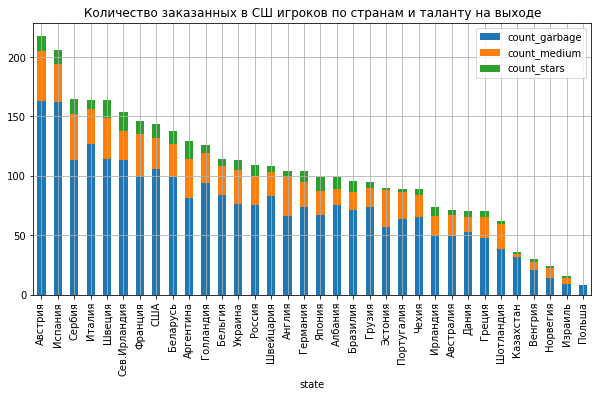

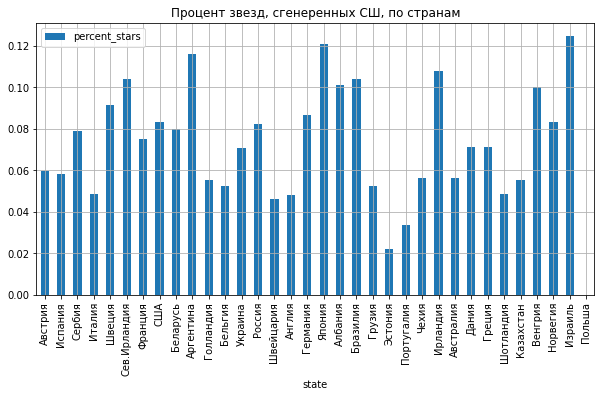

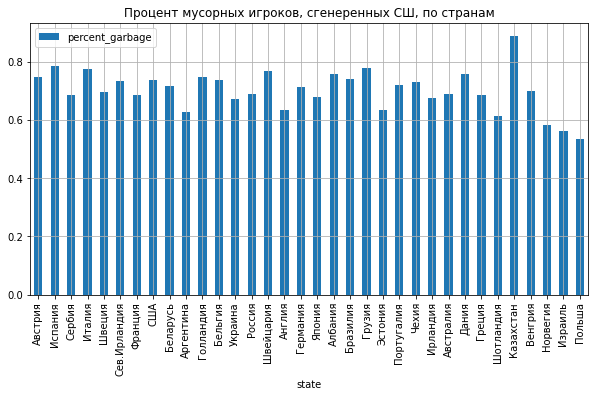

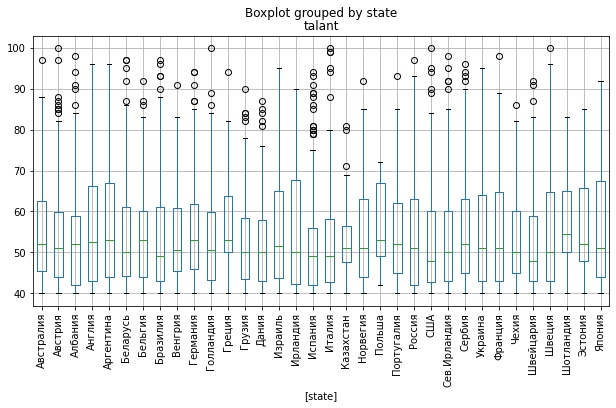

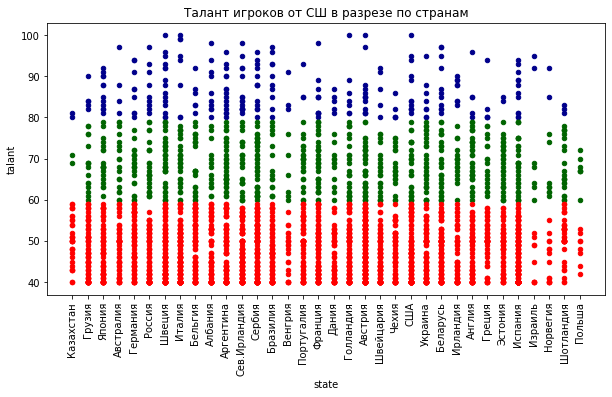

In [11]:
state_stat.sort_values(by='count', ascending=False, inplace=True)
#нарисуем кол-во заказанных в СШ игроков по странам
state_stat.plot(x='state', y=['count_garbage', 'count_medium', 'count_stars'], kind='bar', stacked=True, figsize=(10,5), 
                title='Количество заказанных в СШ игроков по странам и таланту на выходе', grid=True)
#покажем процент звезд по странам
state_stat.plot(x='state', y='percent_stars', kind='bar', figsize=(10,5), title='Процент звезд, сгенеренных СШ, по странам', grid=True)
#покажем процент мусора по странам
state_stat.plot(x='state', y='percent_garbage', kind='bar', figsize=(10,5), title='Процент мусорных игроков, сгенеренных СШ, по странам', grid=True)
#распределение таланта в группировке по странам
all_data[['state', 'talant']].boxplot(by='state', figsize=(10,5), rot=90)
ax = all_data[all_data['talant']>=80].plot.scatter(x="state", y="talant", color="DarkBlue", label="Stars", legend=None)
ax1 = all_data.query('talant<80 and talant>=60').plot.scatter(x="state", y="talant", color="DarkGreen", label="Medium", ax=ax, legend=None)
all_data[all_data['talant']<60].plot.scatter(x="state", y="talant", color="Red", label="Garbage", ax=ax1, rot=90, figsize=(10,5), 
                                             title='Талант игроков от СШ в разрезе по странам', legend=None)

#all_data.plot(x="state", y='talant', kind='scatter', figsize=(10,5), rot=90, title='Талант игроков от СШ в разрезе по странам')

Со странами и клубами пока закончим и поанализируем параметры выпущенных в СШ игроков.
**ПОЗИЦИЯ**

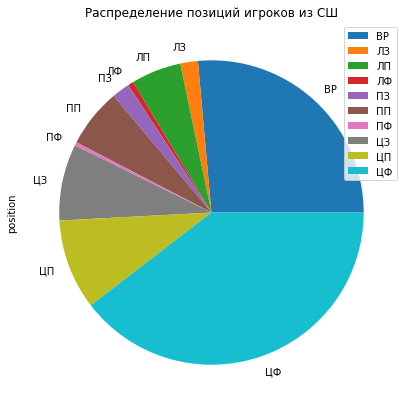

In [23]:
roles = all_data.pivot_table(index='role', values='power', aggfunc='count')
roles.rename(columns={'power':'position'}, inplace=True)
roles.plot.pie(y='position',figsize=(7,7), title='Распределение позиций игроков из СШ')

Отлично видно, что чаще всего заказывают ЦФ. При этом ЦФ заказывают примерно в трети случаев, ВР тоже, а оставшаяся треть делится всеми другими позициями. Это объясняется тем, что ЦФ и ВР на рынке стоят дороже всего (т.к. больше других игроков влияют на результаты игр). Меньше же всех заказывают крайних форвардов. Что достаточно странно, ибо самые популярный тактические схемы последних лет требуют обязательного наличия КФ в составе - по идее КФ должны бы заказываться не реже, чем КП.

**ВОЗРАСТ**

     age
age     
16   846
17   857
18   728
19   617
20   483


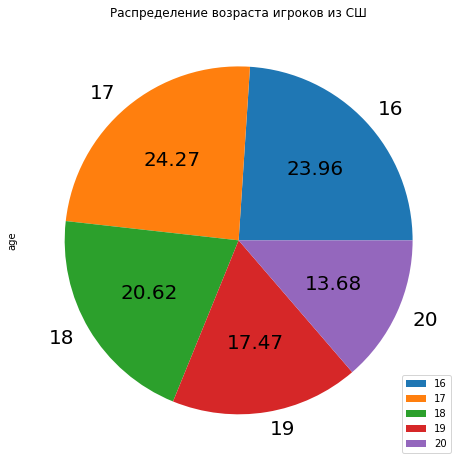

In [22]:
ages = all_data.pivot_table(index='age', values='power', aggfunc='count')
ages.rename(columns={'power':'age'}, inplace=True)
print(ages)
ages.plot.pie(y='age',figsize=(8,8), autopct="%.2f", fontsize=20, title='Распределение возраста игроков из СШ')

А вот тут интереснее. По правилам каждый из возрастов имеет равную вероятность. У нас же получается, что чем меньше возраст, тем чаще он встречается.
Случайность или баг?
**Проверим это**

In [17]:
print('Средний возраст по анализируемой выборке {:.2f}' .format(all_data['age'].mean()))

t_std = np.std([16,17,18,19,20])
t_mean = np.mean([16,17,18,19,20])
distr = st.norm(t_mean, t_std)

print('Теоретический средний возраст по правилам ', t_mean)
result = distr.cdf(all_data['age'].mean())
print('Вероятность того, что такое отклонение среднего возраста от теоретического носит случайный характер {:.1%}'.format(result))
#Ho: mean(age) = 18

Средний возраст по анализируемой выборке 17.73
Теоретический средний возраст по правилам  18.0
Вероятность того, что такое отклонение среднего возраста от теоретического носит случайный характер 42.3%


Как видим, с вероятностью 42% среднее нашей выборки равно теоретическому среднему 18. Т.е. можно сказать, что наблюдаемое на диаграмме выше расхождение носит случайный характер.

**СИЛА**
Сами по себе значения силы здесь не особенно интересны. Скорее, стоит рассмотреть на "лишнюю силу" - разность силы игрока из СШ и базовой силы игрока такого же возраста, определяемой по формуле Сила = Возраст*2-20.

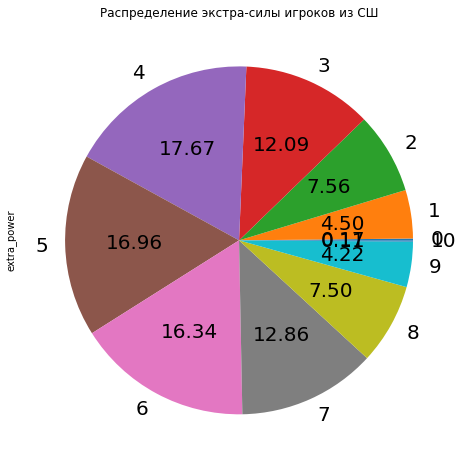

In [21]:
all_data['extra_power'] = all_data['power'] - (2*all_data['age'] - 20)
extras = all_data.pivot_table(index='extra_power', values='power', aggfunc='count')

extras.rename(columns={'power':'extra_power'}, inplace=True)
extras.plot.pie(y='extra_power',figsize=(8,8), autopct="%.2f", fontsize=20, legend=None, title='Распределение экстра-силы игроков из СШ')

Теперь посмотрим есть ли какие-то взаимосвязи между рассмотренными параметрами. Согласно правилам все это независимые друг от друга величины, но вдруг нас обманывают ))?

In [ ]:
test_variables = all_data[['age', 'talant', 'extra_power']]
print(test_variables.corr())
#plt.matshow(test_variables.corr())
#plt.show()

                  age    talant  extra_power
age          1.000000  0.033439    -0.024247
talant       0.033439  1.000000    -0.001659
extra_power -0.024247 -0.001659     1.000000


Как видим, коэффициенты корреляции между любой парой параметров игрока очень малы, т.е. можно говорить о том, что эти параметры при генерации действительно друг от друга не зависят. И на примере двух наиболее популярных позиций, проверим гипотезы, что средние значения этих параметров для этих позиций не отличаются

In [ ]:
# делаем 2 выборки - только ЦФ и только ВР
sample_cf = all_data[all_data['role'] == 'ЦФ']
sample_gk = all_data[all_data['role'] == 'ВР']

print(sample_cf.describe())
print(sample_gk.describe())

#H0 - mean(age('ЦФ')) = mean(age('ЦФ'))
results = st.ttest_ind(sample_cf['age'], sample_gk['age'])
print('p-значение: age ', results.pvalue)

results = st.ttest_ind(sample_cf['talant'], sample_gk['talant'])
print('p-значение: talant ', results.pvalue)

results = st.ttest_ind(sample_cf['extra_power'], sample_gk['extra_power'])
print('p-значение: extra_power ', results.pvalue)

               age       talant  ...           mt  extra_power
count  1397.000000  1397.000000  ...  1397.000000  1397.000000
mean     17.657122    54.216178  ...    42.102362     5.037223
std       1.344830    13.709342  ...     3.994298     2.025989
min      16.000000    40.000000  ...    40.000000     0.000000
25%      16.000000    43.000000  ...    40.000000     4.000000
50%      18.000000    50.000000  ...    40.000000     5.000000
75%      19.000000    61.000000  ...    40.000000     7.000000
max      20.000000   100.000000  ...    70.000000    10.000000

[8 rows x 8 columns]
              age      talant  ...          mt  extra_power
count  933.000000  933.000000  ...  933.000000   933.000000
mean    17.734191   54.599143  ...   41.901393     4.981779
std      1.345027   13.603051  ...    3.785976     2.091955
min     16.000000   40.000000  ...   40.000000     0.000000
25%     17.000000   44.000000  ...   40.000000     4.000000
50%     18.000000   51.000000  ...   40.000000     

Как видим, все гипотезы выполняются при уровне значимости 0,05, т.к. расчетное p-value превышает это значение. Т.о. нет оснований считать, что талант, возраст и экстра-сила зависят от позиции.

Теперь посмотрим, влияют ли на параметры игрока (возраст, талант, экстра-сила) параметры заказа (количество игроков и минимальный талант).

In [ ]:
test_variables = all_data[['age', 'talant', 'extra_power', 'count_players', 'mt']]
print(test_variables.corr())

                    age    talant  extra_power  count_players        mt
age            1.000000  0.033439    -0.024247       0.007400 -0.005549
talant         0.033439  1.000000    -0.001659       0.021334  0.214105
extra_power   -0.024247 -0.001659     1.000000       0.010632 -0.008444
count_players  0.007400  0.021334     0.010632       1.000000  0.136840
mt            -0.005549  0.214105    -0.008444       0.136840  1.000000


Из интересного можно отметить наличие слабой взаимосвязи между талантом сгенеренного игрока и минимальным талантом в заказе. Наличие этой взаимосвязи обусловлено тем, что чем больше МТ, тем больше средний талант сгенеренного игрока за счет отбрасывания талантов меньше МТ. Слабость же взаимосвязи обусловлена тем, что все равно большая часть игроков получает талант близкий к МТ. Мы это увидим дальше. 

Посмотрим на распределение таланта выпускников СШ в зависимости от минимального таланта.
Начнем с гистограммы распределения самого МТ.

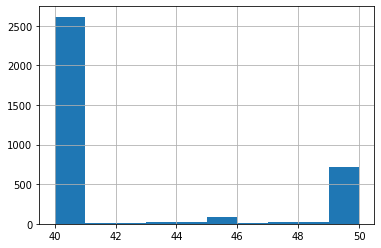

In [ ]:
all_data['mt'].hist(bins=(40,41,42,43,44,45,46,47,48,49,50))

Как видим, подавляющее большинство заказов имеют МТ=40, МТ=50 почти в 5 раз меньше, а всякие промежуточные значения и вовсе имеют единичную частоту.
В связи с этим можно просто рассматривать две разных группы игроков - с МТ40 и с МТ50.

[1435, 497, 297, 203, 131, 48]
[429, 120, 87, 40, 16]


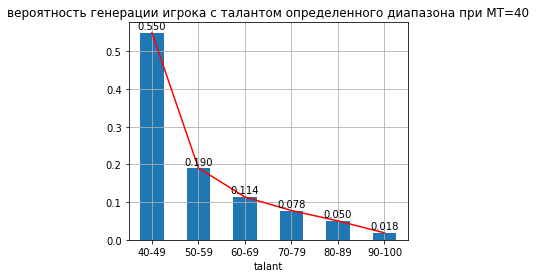

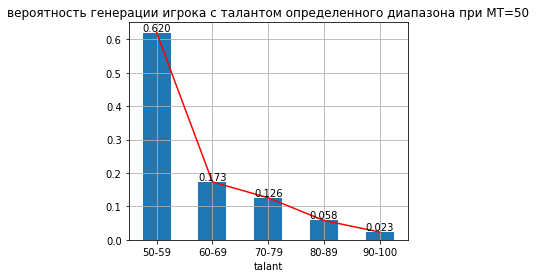

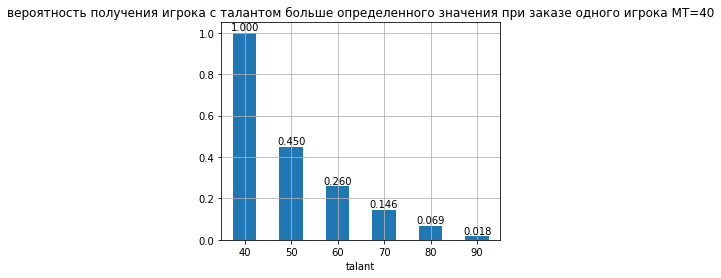

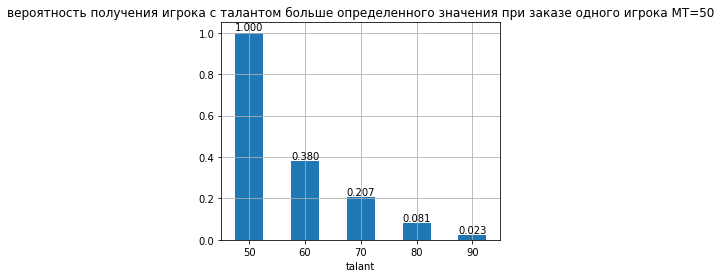

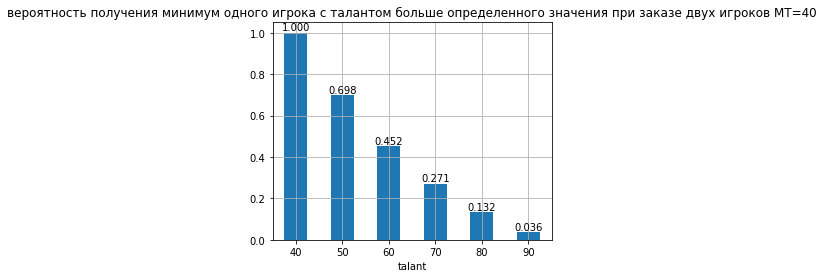

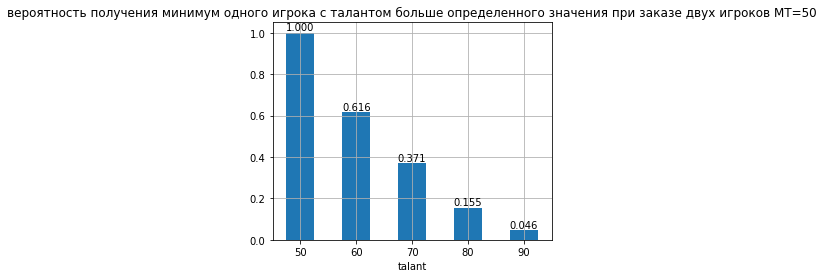

   talant  percent_mt40  percent2_mt40  percent_mt50  percent2_mt50
0      40      1.000000       1.000000           NaN            NaN
1      50      0.450402       0.697942      1.000000       1.000000
2      60      0.260054       0.452479      0.380058       0.615672
3      70      0.146304       0.271203      0.206647       0.370592
4      80      0.068556       0.132412      0.080925       0.155301
5      90      0.018384       0.036430      0.023121       0.045708


In [26]:
#all_data.query('mt == 40 or mt == 50').hist(column='talant', by='mt', bins=6)
#и то же самое в процентном соотношении
t40 = []
t50 = []
for i in range(6):  
  t40.append(all_data.query('mt == 40 and talant>=40+@i*10 and talant<40+(@i+1)*10')['talant'].count())
for i in range(5):  
  t50.append(all_data.query('mt == 50 and talant>=50+@i*10 and talant<50+(@i+1)*10')['talant'].count())
print(t40)
print(t50)

index40 = ['40-49', '50-59', '60-69', '70-79', '80-89', '90-100']
df40 = pd.DataFrame(t40, index=index40, columns=['count'])
index50 = ['50-59', '60-69', '70-79', '80-89', '90-100']
df50 = pd.DataFrame(t50, index=index50, columns=['count'])
df40['percent'] = df40['count'] / df40['count'].sum()
df50['percent'] = df50['count'] / df50['count'].sum()
df50.reset_index(inplace=True)
df40.reset_index(inplace=True)
df40.rename(columns={'index': 'talant'}, inplace=True)
df50.rename(columns={'index': 'talant'}, inplace=True)
#print(df40)
#print(df50)

ax = df40.plot(x='talant', y='percent', kind='bar', figsize=(5,4), 
                title='вероятность генерации игрока с талантом определенного диапазона при МТ=40', grid=True, legend=None)
df40.plot(x='talant', y='percent', figsize=(5,4), ax=ax,
                title='вероятность генерации игрока с талантом определенного диапазона при МТ=40', grid=True, color='Red', legend=None)

x0 = np.arange(6)
y0 = np.array(df40['percent'])
for x, y in zip(x0, y0):
    plt.text(x, y + 0.03, '%.3f' %y, ha='center', va = 'top')
plt.show()

ax = df50.plot(x='talant', y='percent', kind='bar', figsize=(5,4), 
                title='вероятность генерации игрока с талантом определенного диапазона при МТ=50', grid=True, legend=None)
df50.plot(x='talant', y='percent', figsize=(5,4), ax=ax,
                title='вероятность генерации игрока с талантом определенного диапазона при МТ=50', grid=True, color='Red', legend=None)

x0 = np.arange(5)
y0 = np.array(df50['percent'])
for x, y in zip(x0, y0):
    plt.text(x, y + 0.03, '%.3f' %y, ha='center', va = 'top')
plt.show()

#построим еще более интересные графики - вероятность получения игрока с талантом более заданного
index40 = [40, 50, 60, 70, 80, 90]
index50 = [50, 60, 70, 80, 90]
df40['talant'] = index40
df50['talant'] = index50

t40 = [
        df40['percent'].sum(),
        df40['percent'].sum() - df40['percent'][0],
        df40['percent'].sum() - df40['percent'][0] - df40['percent'][1],
        df40['percent'].sum() - df40['percent'][0] - df40['percent'][1] - df40['percent'][2],
        df40['percent'].sum() - df40['percent'][0] - df40['percent'][1] - df40['percent'][2] - df40['percent'][3],
        df40['percent'].sum() - df40['percent'][0] - df40['percent'][1] - df40['percent'][2] - df40['percent'][3] - df40['percent'][4]
      ]

t50 = [
        df50['percent'].sum(),
        df50['percent'].sum() - df50['percent'][0],
        df50['percent'].sum() - df50['percent'][0] - df50['percent'][1],
        df50['percent'].sum() - df50['percent'][0] - df50['percent'][1] - df50['percent'][2],
        df50['percent'].sum() - df50['percent'][0] - df50['percent'][1] - df50['percent'][2] - df50['percent'][3]        
      ]

df40['percent'] = t40
df50['percent'] = t50

#сразу посчитаем вероятности для заказа двух игроков
df40['percent2'] = df40['percent'] + df40['percent']*(1-df40['percent'])
df50['percent2'] = df50['percent'] + df50['percent']*(1-df50['percent'])


ax = df40.plot(x='talant', y='percent', kind='bar', figsize=(5,4), 
                title='вероятность получения игрока с талантом больше определенного значения при заказе одного игрока МТ=40', grid=True, legend=None)
df40.plot(x='talant', y='percent', figsize=(5,4), ax=ax,
                title='вероятность получения игрока с талантом больше определенного значения при заказе одного игрока МТ=40', grid=True, color='Red', legend=None)

x0 = np.arange(6)
y0 = np.array(df40['percent'])
for x, y in zip(x0, y0):
    plt.text(x, y + 0.05, '%.3f' %y, ha='center', va = 'top')
plt.show()

ax = df50.plot(x='talant', y='percent', kind='bar', figsize=(5,4), 
                title='вероятность получения игрока с талантом больше определенного значения при заказе одного игрока МТ=50', grid=True, legend=None)
df50.plot(x='talant', y='percent', figsize=(5,4), ax=ax,
                title='вероятность получения игрока с талантом больше определенного значения при заказе одного игрока МТ=50', grid=True, color='Red', legend=None)

x0 = np.arange(5)
y0 = np.array(df50['percent'])
for x, y in zip(x0, y0):
    plt.text(x, y + 0.05, '%.3f' %y, ha='center', va = 'top')
plt.show()

ax = df40.plot(x='talant', y='percent2', kind='bar', figsize=(5,4), grid=True, legend=None)
df40.plot(x='talant', y='percent2', figsize=(5,4), ax=ax,
                title='вероятность получения минимум одного игрока с талантом больше определенного значения при заказе двух игроков МТ=40', grid=True, color='Red', legend=None)

x0 = np.arange(6)
y0 = np.array(df40['percent2'])
for x, y in zip(x0, y0):
    plt.text(x, y + 0.05, '%.3f' %y, ha='center', va = 'top')
plt.show()

ax = df50.plot(x='talant', y='percent2', kind='bar', figsize=(5,4), grid=True, legend=None)
df50.plot(x='talant', y='percent2', figsize=(5,4), ax=ax,
                title='вероятность получения минимум одного игрока с талантом больше определенного значения при заказе двух игроков МТ=50', grid=True, color='Red', legend=None)

x0 = np.arange(5)
y0 = np.array(df50['percent2'])
for x, y in zip(x0, y0):
    plt.text(x, y + 0.05, '%.3f' %y, ha='center', va = 'top')
plt.show()

df40 = df40.join(df50.set_index('talant'), on='talant', lsuffix='_mt40', rsuffix='_mt50')
df40.drop(columns=['count_mt40', 'count_mt50'], inplace=True)
print(df40)